# <center> Multiscale Geographically Weighted Regression Workshop </center>
## <center> Part II - Mapping Results </center>
<center> Mehak Sachdeva </center>
<center> Spatial Analysis Research Center </center>
<center> School of Geographical Sciences and Urban Planning </center>
<center> Arizona State University </center>



## Download the zipped data folder [here](https://github.com/mehak-sachdeva/MGWR_Workshop_2020/archive/master.zip) to follow along!



# Installing and importing libraries for Python for mapping results

In [ ]:
! pip install -U mgwr
! pip install geopandas
! pip install pyshp
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz 2>/dev/null | tar xz
!apt-get install -qq g++ make
import os
os.chdir('/content/spatialindex-src-1.8.5')
!./configure 2>&1 >/dev/null && make 2>&1 >/dev/null && make install && ldconfig
!pip install -q rtree
!pip install matplotlib_scalebar

In [ ]:
# A bit of imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load in the r magic
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
sns.set(color_codes=True)
from sklearn import linear_model
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_scalebar.scalebar import ScaleBar
import statsmodels.api as statm

import libpysal as ps
from mgwr.gwr import GWR
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Gaussian, Binomial, Poisson
import multiprocessing as mp
pool = mp.Pool()
import io

from google.colab import files
from IPython.display import Image

Here we need to upload the csv and txt files from running the MGWR software.

In [ ]:
#Upload the results .csv file output from the MGWR software
uploaded = files.upload()

Saving MGWR_HIV_result_results.csv to MGWR_HIV_result_results.csv
Saving MGWR_HIV_result_summary.txt to MGWR_HIV_result_summary.txt


In [ ]:
census = pd.read_csv(io.StringIO(uploaded['MGWR_HIV_result_results.csv'].decode('utf-8')),sep=',')
census.columns

Index(['geoid', 'x_coor', 'y_coor', 'y', 'ols_residual', 'mgwr_yhat',
       'mgwr_residual', 'localR2', 'beta_Intercept',
       'beta_%_no_health_insurance', 'beta_%_below_poverty',
       'beta_%_vacant_housing', 'beta_%_white', 'se_Intercept',
       'se_%_no_health_insurance', 'se_%_below_poverty', 'se_%_vacant_housing',
       'se_%_white', 't_Intercept', 't_%_no_health_insurance',
       't_%_below_poverty', 't_%_vacant_housing', 't_%_white', 'p_Intercept',
       'p_%_no_health_insurance', 'p_%_below_poverty', 'p_%_vacant_housing',
       'p_%_white', 'sumW_Intercept', 'sumW_%_no_health_insurance',
       'sumW_%_below_poverty', 'sumW_%_vacant_housing', 'sumW_%_white'],
      dtype='object')

# Data Preprocessing

Any rows that have t-values less than their corresponding thresholds will be excluded from our final dataframe for the map.

In [ ]:
b_cols = ['beta_Intercept','beta_%_no_health_insurance','beta_%_below_poverty','beta_%_vacant_housing','beta_%_white']
bt_cols = ['bt_Intercept','bt_%_no_health_insurance','bt_%_below_poverty','bt_%_vacant_housing','bt_%_white']
t_cols = ['t_Intercept','t_%_no_health_insurance','t_%_below_poverty','t_%_vacant_housing','t_%_white']

t_crit = [2.790, 2.035, 2.766, 2.205, 2.794]

In [ ]:
for i in range(len(b_cols)):
    census.loc[census[t_cols[i]] >=t_crit[i], bt_cols[i]] = census[b_cols[i]]
    census.loc[census[t_cols[i]] <=-t_crit[i], bt_cols[i]] = census[b_cols[i]]

We upload the shapefile needed for mapping. Here we have a shapefile of New York City divided into census tracts.

In [ ]:
uploaded = files.upload()
#upload the census_tract files from the downloaded folder

Saving zipcode_NYC.cpg to zipcode_NYC.cpg
Saving zipcode_NYC.dbf to zipcode_NYC.dbf
Saving zipcode_NYC.prj to zipcode_NYC.prj
Saving zipcode_NYC.sbn to zipcode_NYC.sbn
Saving zipcode_NYC.sbx to zipcode_NYC.sbx
Saving zipcode_NYC.shp to zipcode_NYC.shp
Saving zipcode_NYC.shp.xml to zipcode_NYC.shp.xml
Saving zipcode_NYC.shx to zipcode_NYC.shx


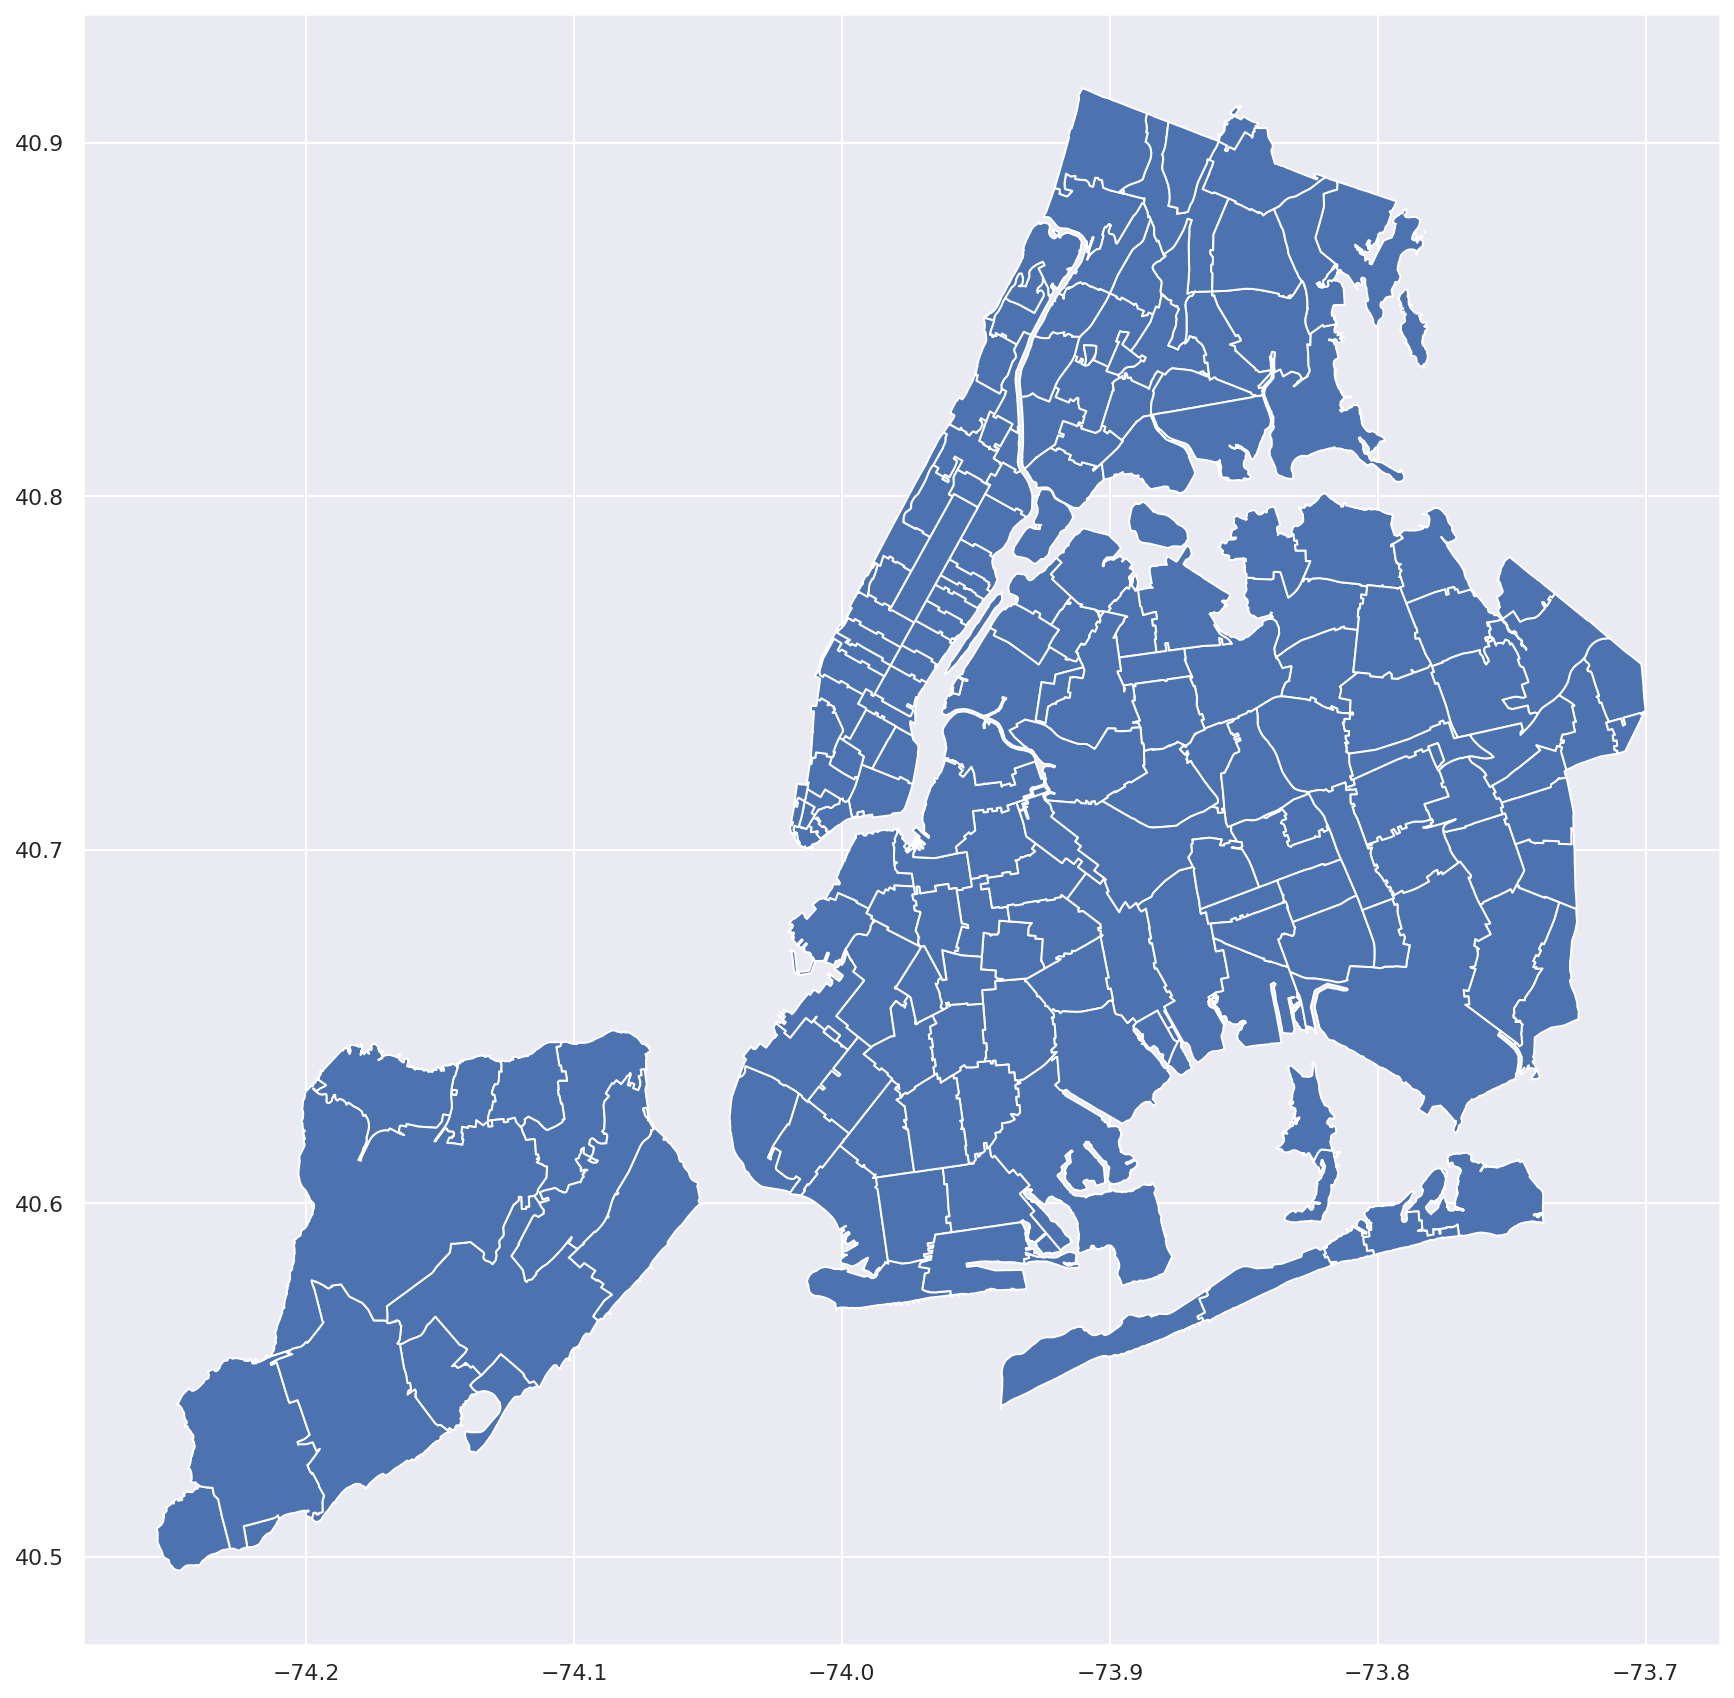

In [ ]:
c='zipcode_NYC.shp'
crs = {'EPSG':'4326'}
geo = gpd.read_file(c,crs=crs)[['geometry','GEOID10']]
fig,ax = plt.subplots(figsize=(20,15))
geo.plot(ax=ax)

The dataframe containing geometry is spatial joined with the dataframe containing variables so we can plot out the correlation values. Each red dot is supposed to be the center point of each census tract so this shows that the two dataframes are perfectly matched except for some small errors where the dots are shown to be outside of the census tracts.

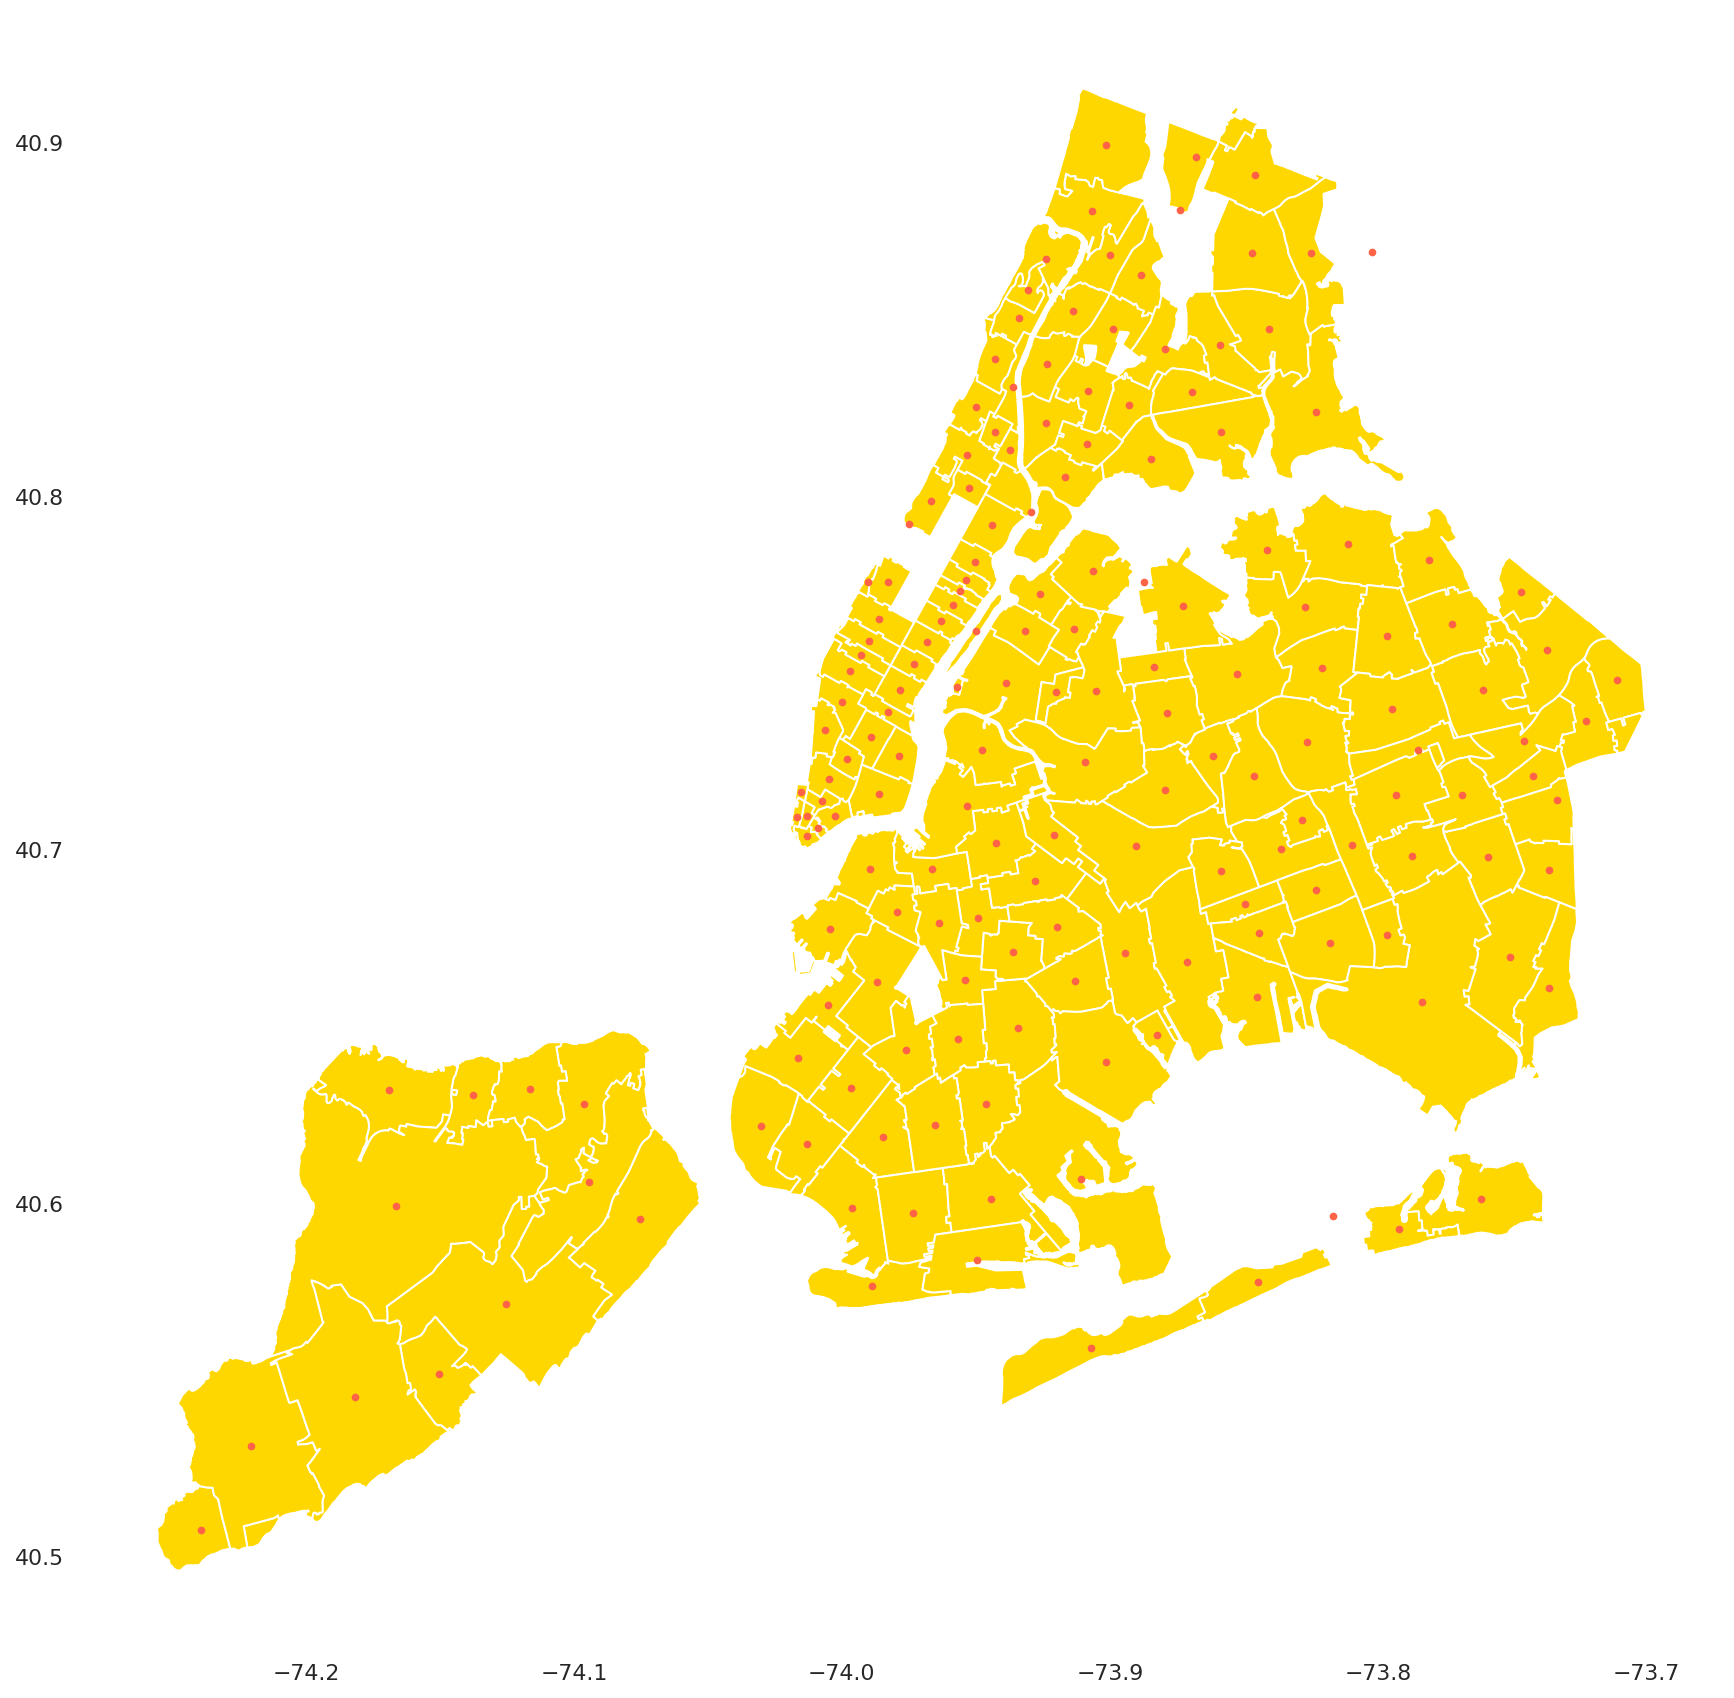

In [ ]:
coords = np.array(list(zip(census['x_coor'],census['y_coor'])))
geom_points = [Point(xy) for xy in coords]
geo_df = gpd.GeoDataFrame(census,crs={'init':'epsg:4326'},geometry=geom_points)
geo_df = geo_df.rename(columns={'geoid':'GEOID10'})
geo_df = geo_df.to_crs(epsg=4326)
final_geo = gpd.sjoin(geo, geo_df, how='inner',op='contains',lsuffix='left',rsuffix='right')


fig,ax = plt.subplots(figsize=(20,15))
ax.set_facecolor('white')
final_geo.plot(ax=ax, color='gold')
geo_df.plot(ax=ax, markersize=8,alpha=1,color='tomato',marker="o")

In [ ]:
final_geo.head()

,geometry,GEOID10_left,index_right,GEOID10_right,x_coor,y_coor,y,ols_residual,mgwr_yhat,mgwr_residual,localR2,beta_Intercept,beta_%_no_health_insurance,beta_%_below_poverty,beta_%_vacant_housing,beta_%_white,se_Intercept,se_%_no_health_insurance,se_%_below_poverty,se_%_vacant_housing,se_%_white,t_Intercept,t_%_no_health_insurance,t_%_below_poverty,t_%_vacant_housing,t_%_white,p_Intercept,p_%_no_health_insurance,p_%_below_poverty,p_%_vacant_housing,p_%_white,sumW_Intercept,sumW_%_no_health_insurance,sumW_%_below_poverty,sumW_%_vacant_housing,sumW_%_white,bt_Intercept,bt_%_no_health_insurance,bt_%_below_poverty,bt_%_vacant_housing,bt_%_white
0,"POLYGON ((-73.98775 40.74407, -73.98819 40.743...",10001,0,10001,-73.9971,40.7507,1.733879,1.846619,0.673889,1.059990,0.381346,0.776028,-0.104440,0.294972,0.047765,-0.171398,0.122045,0.055497,0.123184,0.063713,0.149080,6.358542,-1.881896,2.394560,0.749693,-1.149702,1.700000e-09,0.061501,0.017691,0.454440,0.251827,20.699430,111.292159,20.699430,83.701256,20.699430,0.776028,NaN,NaN,NaN,NaN
1,"POLYGON ((-73.99606 40.70921, -73.99608 40.709...",10002,1,10002,-73.9862,40.7158,0.204352,-0.581094,0.868143,-0.663790,0.308469,0.557114,-0.104843,0.173473,0.044522,-0.181137,0.119567,0.055469,0.123234,0.061706,0.147980,4.659442,-1.890124,1.407676,0.721520,-1.224065,6.230000e-06,0.060385,0.160991,0.471547,0.222564,18.684196,111.222760,18.684196,84.864779,18.684196,0.557114,NaN,NaN,NaN,NaN
2,"POLYGON ((-73.98859 40.72301, -73.98864 40.722...",10003,2,10003,-73.9892,40.7318,0.413215,0.816959,0.483245,-0.070030,0.346948,0.689844,-0.105048,0.221849,0.046487,-0.145232,0.122906,0.055444,0.124845,0.063244,0.149573,5.612790,-1.894679,1.777003,0.735037,-0.970979,7.620000e-08,0.059775,0.077295,0.463296,0.332891,20.074133,113.076744,20.074133,83.197819,20.074133,0.689844,NaN,NaN,NaN,NaN
3,"MULTIPOLYGON (((-74.00801 40.70799, -74.00827 ...",10004,3,10004,-74.0130,40.7038,0.241776,0.437435,0.230312,0.011465,0.310457,0.480593,-0.099393,0.205371,0.041218,-0.208019,0.117126,0.055806,0.126466,0.060552,0.147069,4.103200,-1.781046,1.623920,0.680708,-1.414429,6.220000e-05,0.076630,0.106183,0.496951,0.159003,18.952519,100.464541,18.952519,81.937470,18.952519,0.480593,NaN,NaN,NaN,NaN
4,"POLYGON ((-74.00766 40.70320, -74.00783 40.703...",10005,4,10005,-74.0089,40.7061,-0.095278,-0.231955,0.362705,-0.457984,0.312035,0.499745,-0.100446,0.210017,0.041638,-0.200322,0.117643,0.055726,0.126933,0.060756,0.147382,4.247975,-1.802484,1.654547,0.685334,-1.359202,3.490000e-05,0.073180,0.099799,0.494035,0.175822,19.546115,102.851470,19.546115,82.496685,19.546115,0.499745,NaN,NaN,NaN,NaN


# Visualizing the results


In [ ]:
import scipy as sp
import shapefile as shp

import matplotlib as mpl
import matplotlib.pyplot as plt
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))

In [ ]:
def mapp(col,name,color,title,size,normal=False):  
    vmi=min(col[name])
    vma=max(col[name])
    figsize=(14,10)
    colors = 10
    norm = MidpointNormalize(vmin=vmi, vmax=vma, midpoint=0)
    colors = 6
    fig, ax = plt.subplots(1, figsize=(size, size))

    if normal==True:
        col.plot(column=name, ax=ax,cmap=color,figsize=figsize,k=colors, linewidth=0.5,norm=norm)
    else:
        col.plot(column=name, ax=ax,cmap=color,figsize=figsize,k=colors, linewidth=0.5)

    ax.axis("off")

    Scalebar = ScaleBar(100000,location='lower left') # 1 pixel = 0.2 meter
    scatter = ax.collections[-1]

    plt.colorbar(scatter, ax=ax, extend='min',orientation='horizontal',fraction=0.046, pad=0.04)
    col.boundary.plot(ax=ax,color='grey',alpha=0.2)
   
    plt.title(title)
    plt.show()

In [ ]:
uploaded = files.upload()

Saving HIV_NYC_GWR_selected (1).csv to HIV_NYC_GWR_selected (1) (1).csv


In [ ]:
variables = pd.read_csv(io.StringIO(uploaded['HIV_NYC_GWR_selected (1).csv'].decode('utf-8')),sep=',')

In [ ]:
geo_variables = geo.merge(variables, left_on = 'GEOID10', right_on = 'geoid')

In [ ]:
geo_variables.head()

For visualization, the variables with a positive correlation with HIV cases are mapped with blue color and the variables with a negative correlation with HIV cases are mapped with red color.

Since in previous steps we marked off any rows whose t-values are not significant enough, it makes sense that some of the census tracts don't have values attached to them. The way to interpret the map is that the darker the color, the more positive/negative correlation a variables has with HIV cases based on a census tract. Since one of the conditions that has to be satisfied for MGWR is that the dependent variable is normally distributed, we have log transformed the number of HIV cases. So for a certain census tract with its beta value β, **a unit increase in the variable means (exp(β) - 1) increase in the HIV cases** while holding all the other variables constant.

Note that since we also standardize all the independent variables, the values used for the regression are also not the exact values.


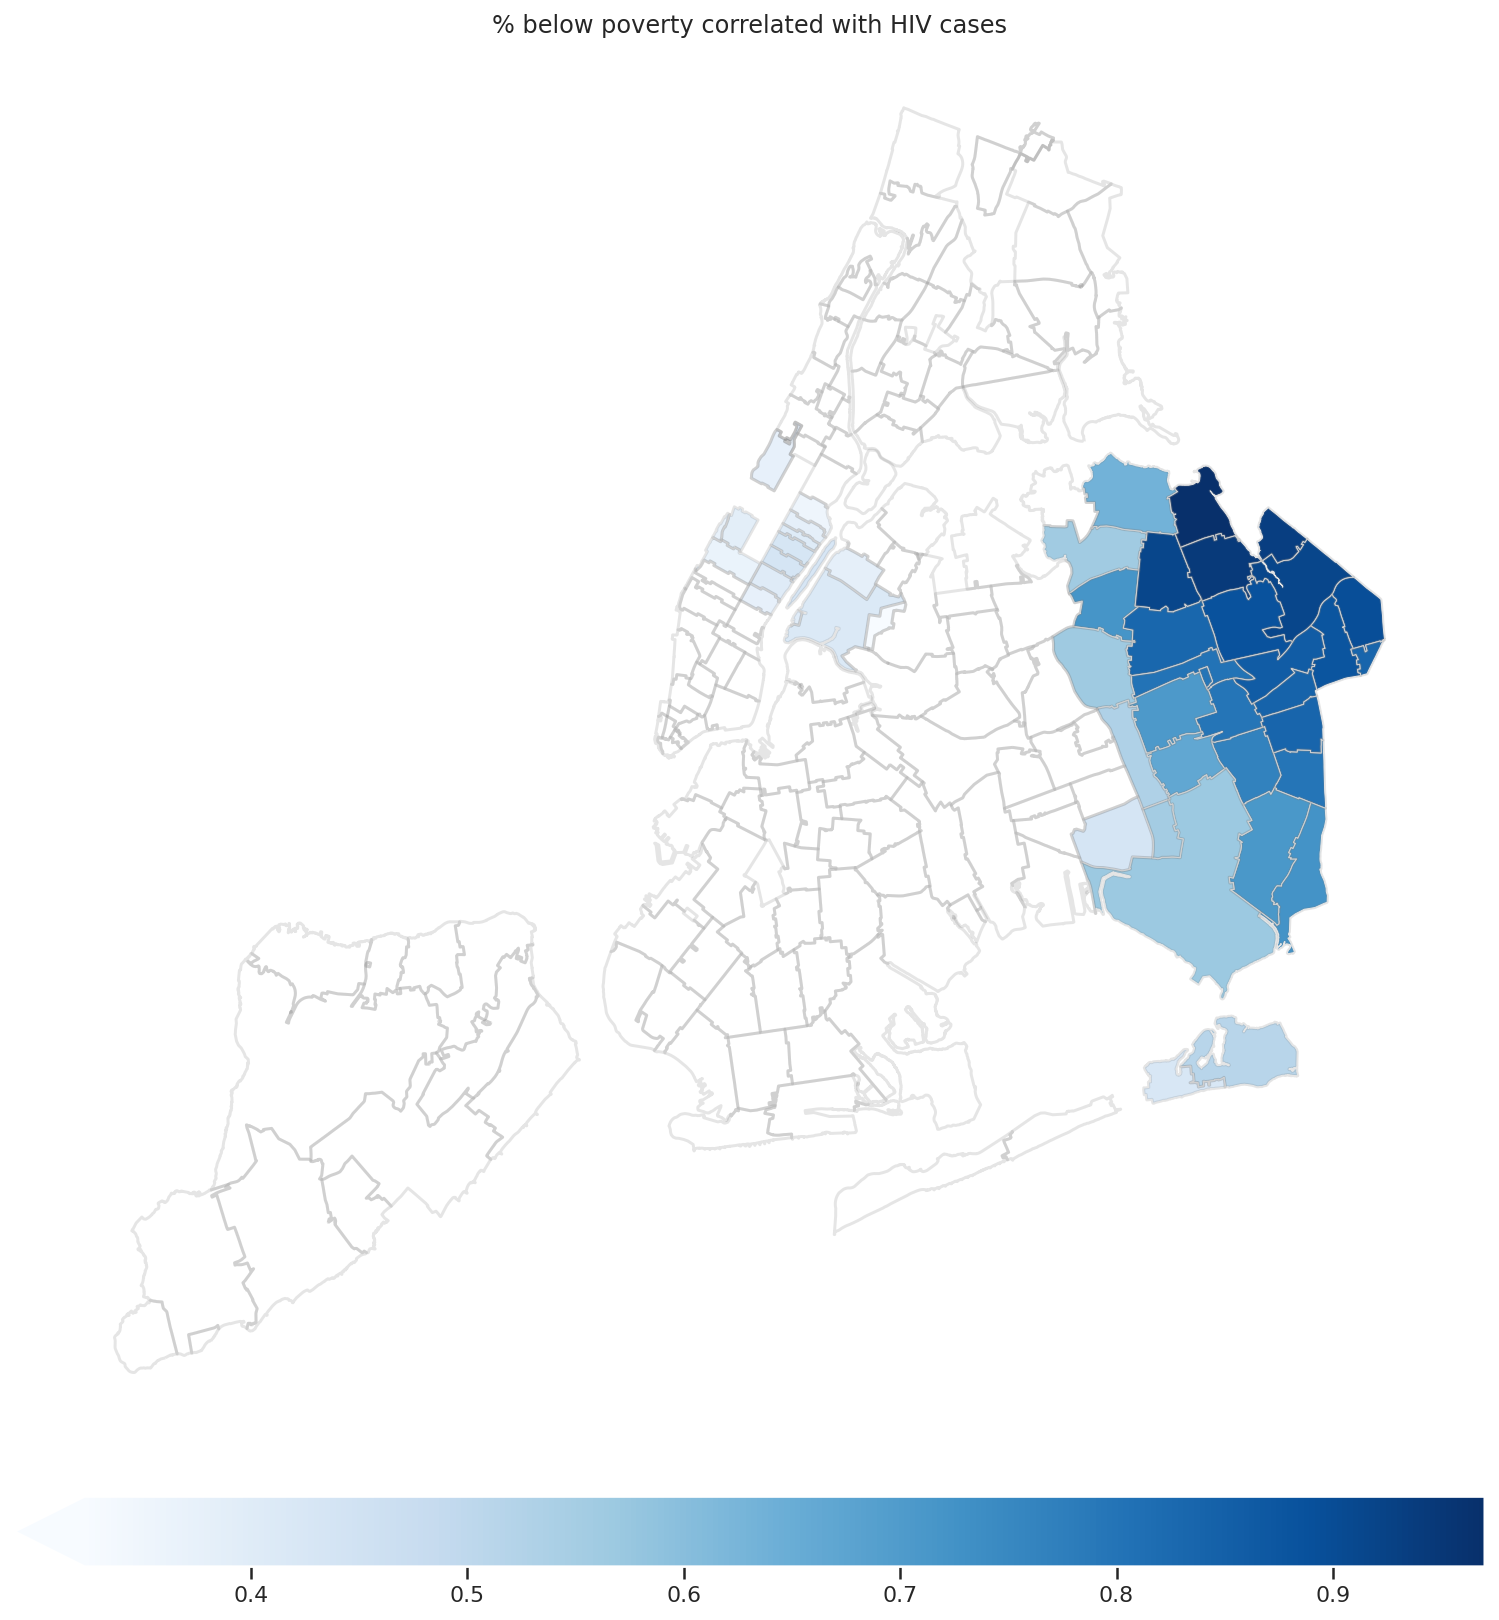

In [ ]:
mapp(col=final_geo,name='bt_%_below_poverty',color='Blues', title = '% below poverty correlated with HIV cases',size = 14, normal=False)

For example, here, a unit of increase in percentage of people in East Queens area means about (exp(0.8) - 1) = 122% increase in the number of HIV cases. 
 

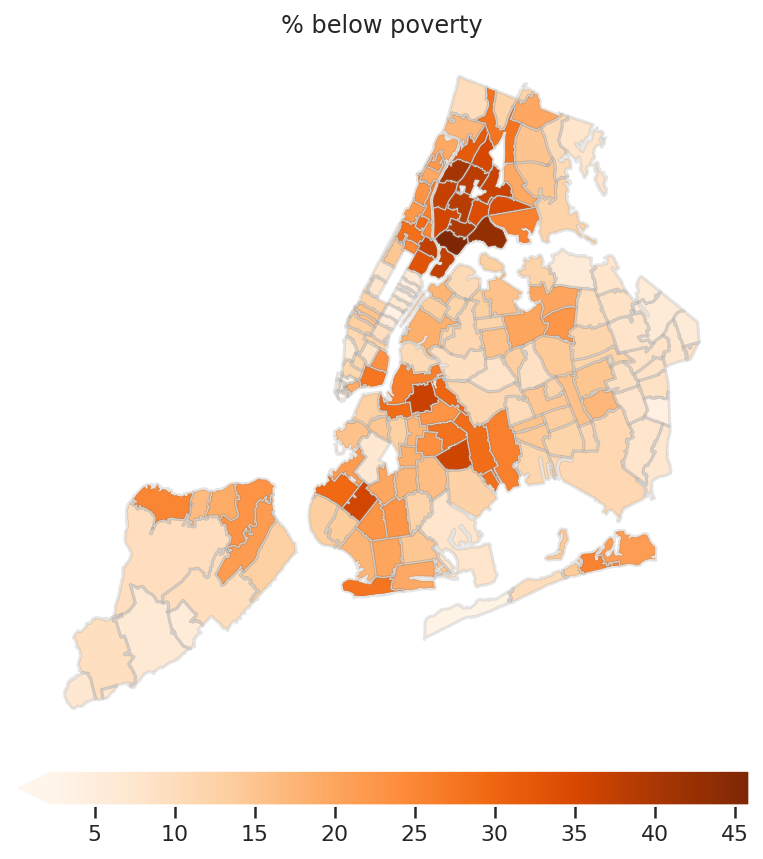

In [ ]:
mapp(col=geo_variables,name='%_below_poverty',color='Oranges', title = '% below poverty', size = 7, normal=False)

My understanding is that what this is saying is that in East Queens, the number of HIV cases is more sensitive to the percentage of people below poverty. This seems to be reasonable if you are to compare the correaltion map with a poverty map below as shown above. East Queens area is one of the richest ares in New York based on the poverty map while having not so many people. So in general this shows that HIV cases in the area is more sensitive to people who are living under poverty.

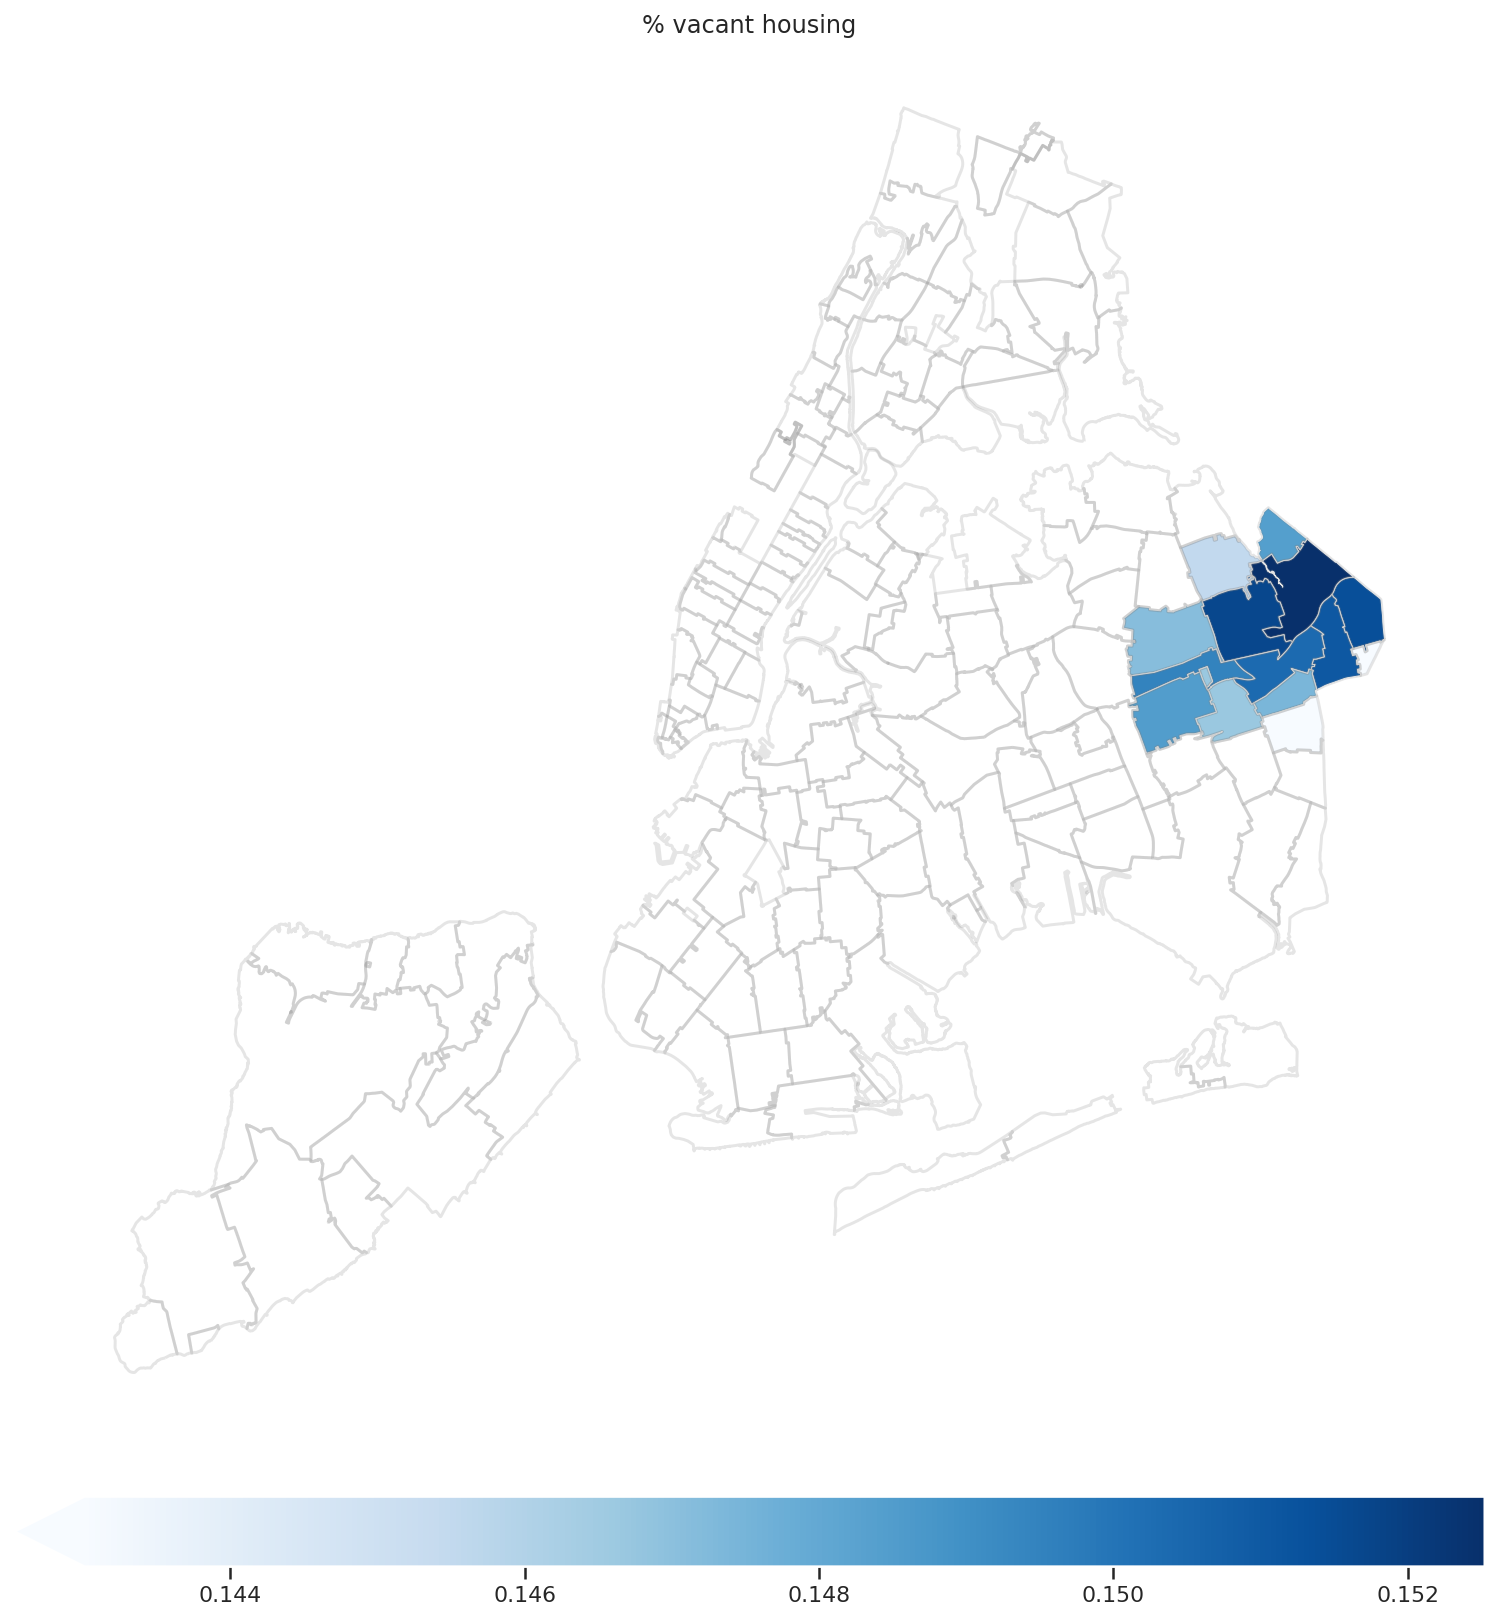

In [ ]:
mapp(col=final_geo,name='bt_%_vacant_housing',color='Blues', title = '% vacant housing correlated with HIV cases', normal=False)

In general % vacant housing is shown to have very little correlation with HIV cases. Even in places where we can say that there is a correlation, the factor of positive correlation is not very high.

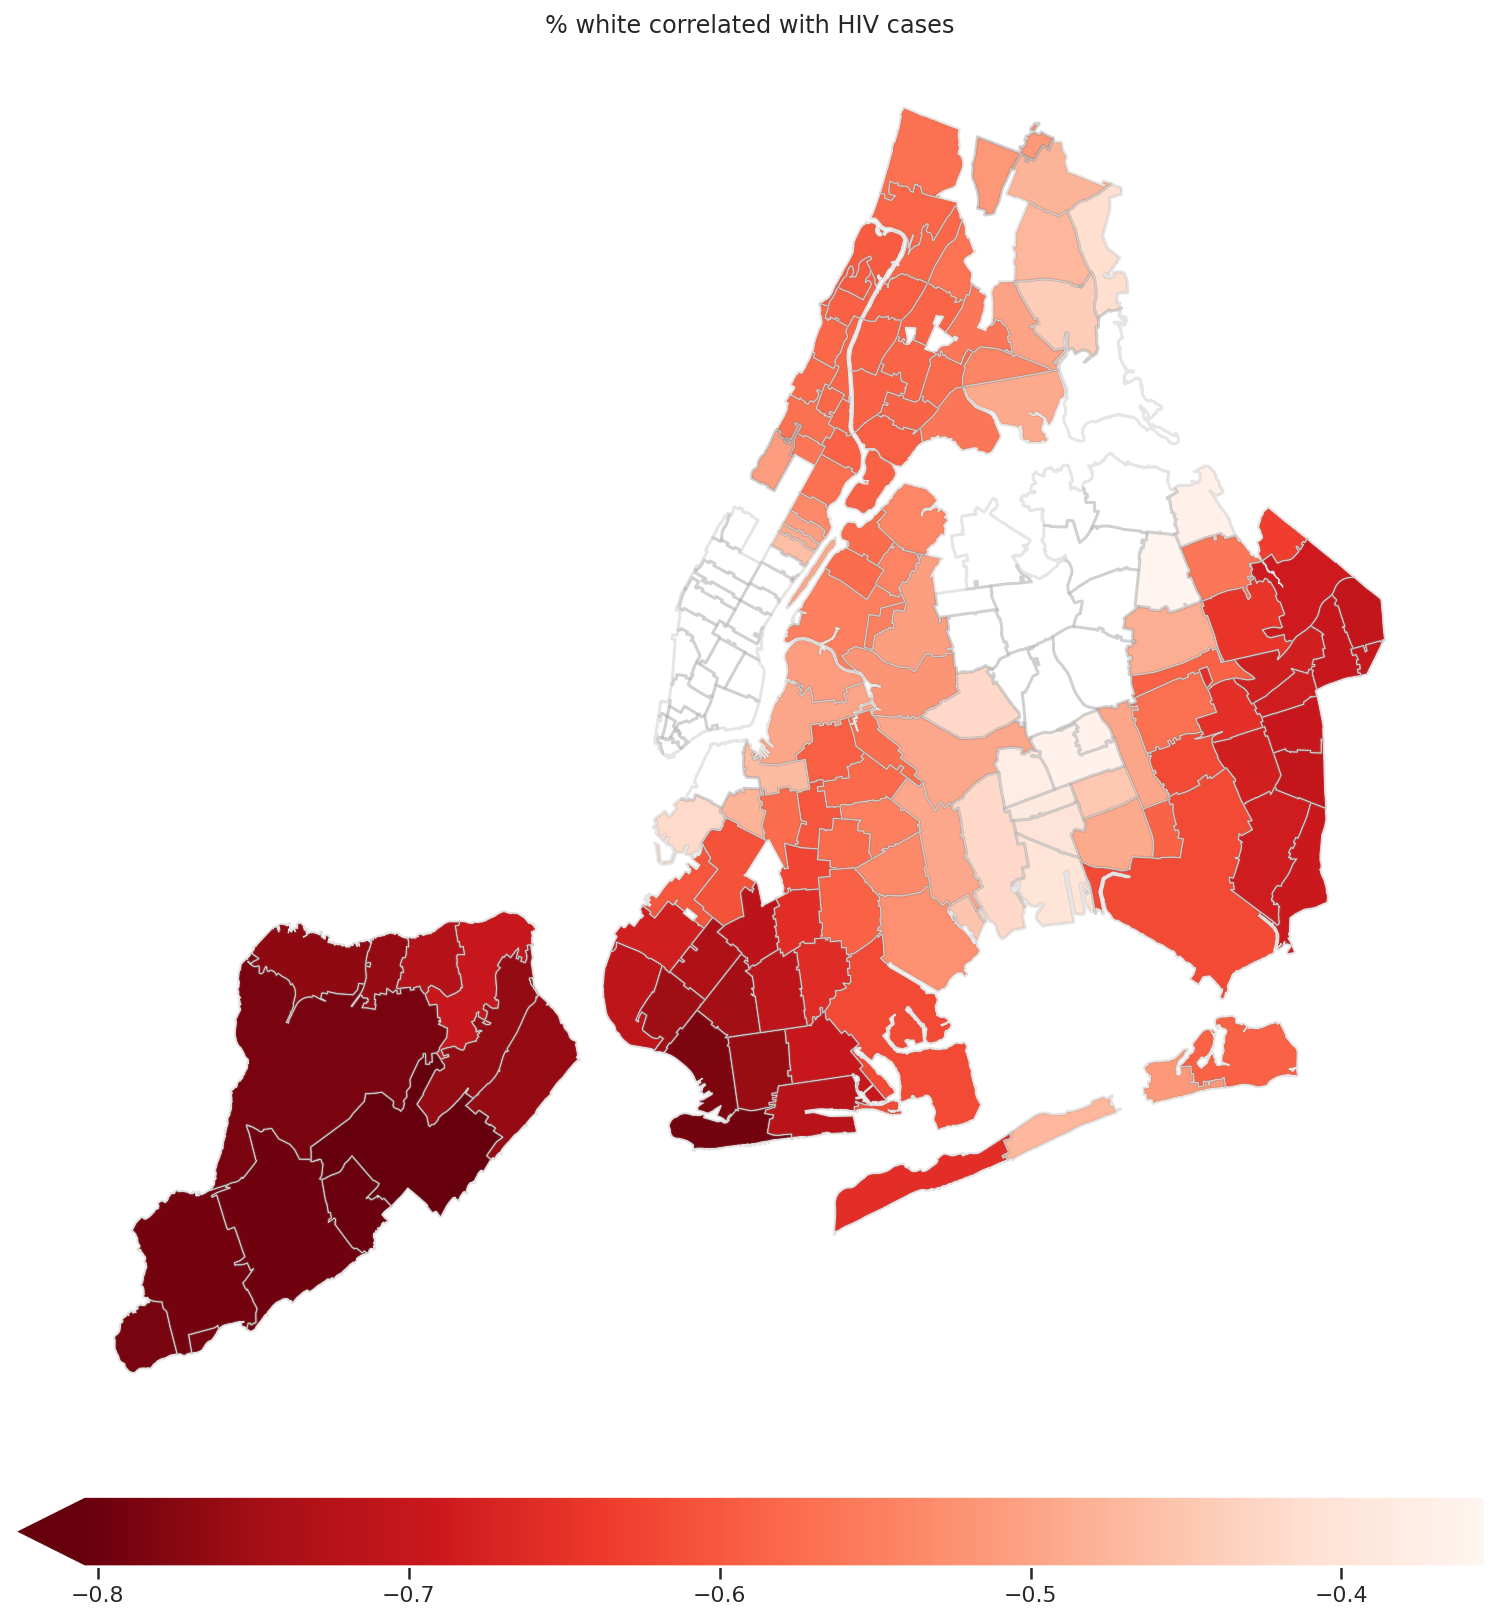

In [ ]:
mapp(col=final_geo,name='bt_%_white',color='Reds_r',title = '% white correlated with HIV cases', normal=False)

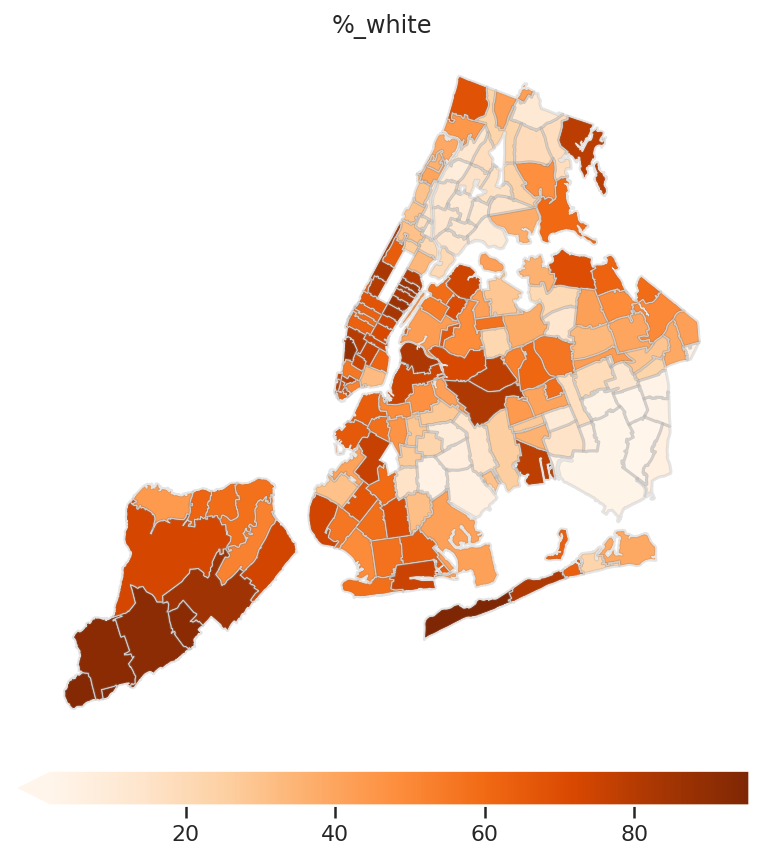

In [ ]:
mapp(col=geo_variables,name='%_white',color='Oranges', title = '%_white', size = 7, normal=False)

The correlation map shows that the number of HIV cases decrease as white population increases for most places in New York. If you are to compare the correlation map with the variable map for percentage of white population, the maps look pretty similar in terms of the colors. Staten Island has the biggest white population percentage and it makes sense that a unit of increase of white population percentage in Staten Island would have more effect than places with less white population percentages.

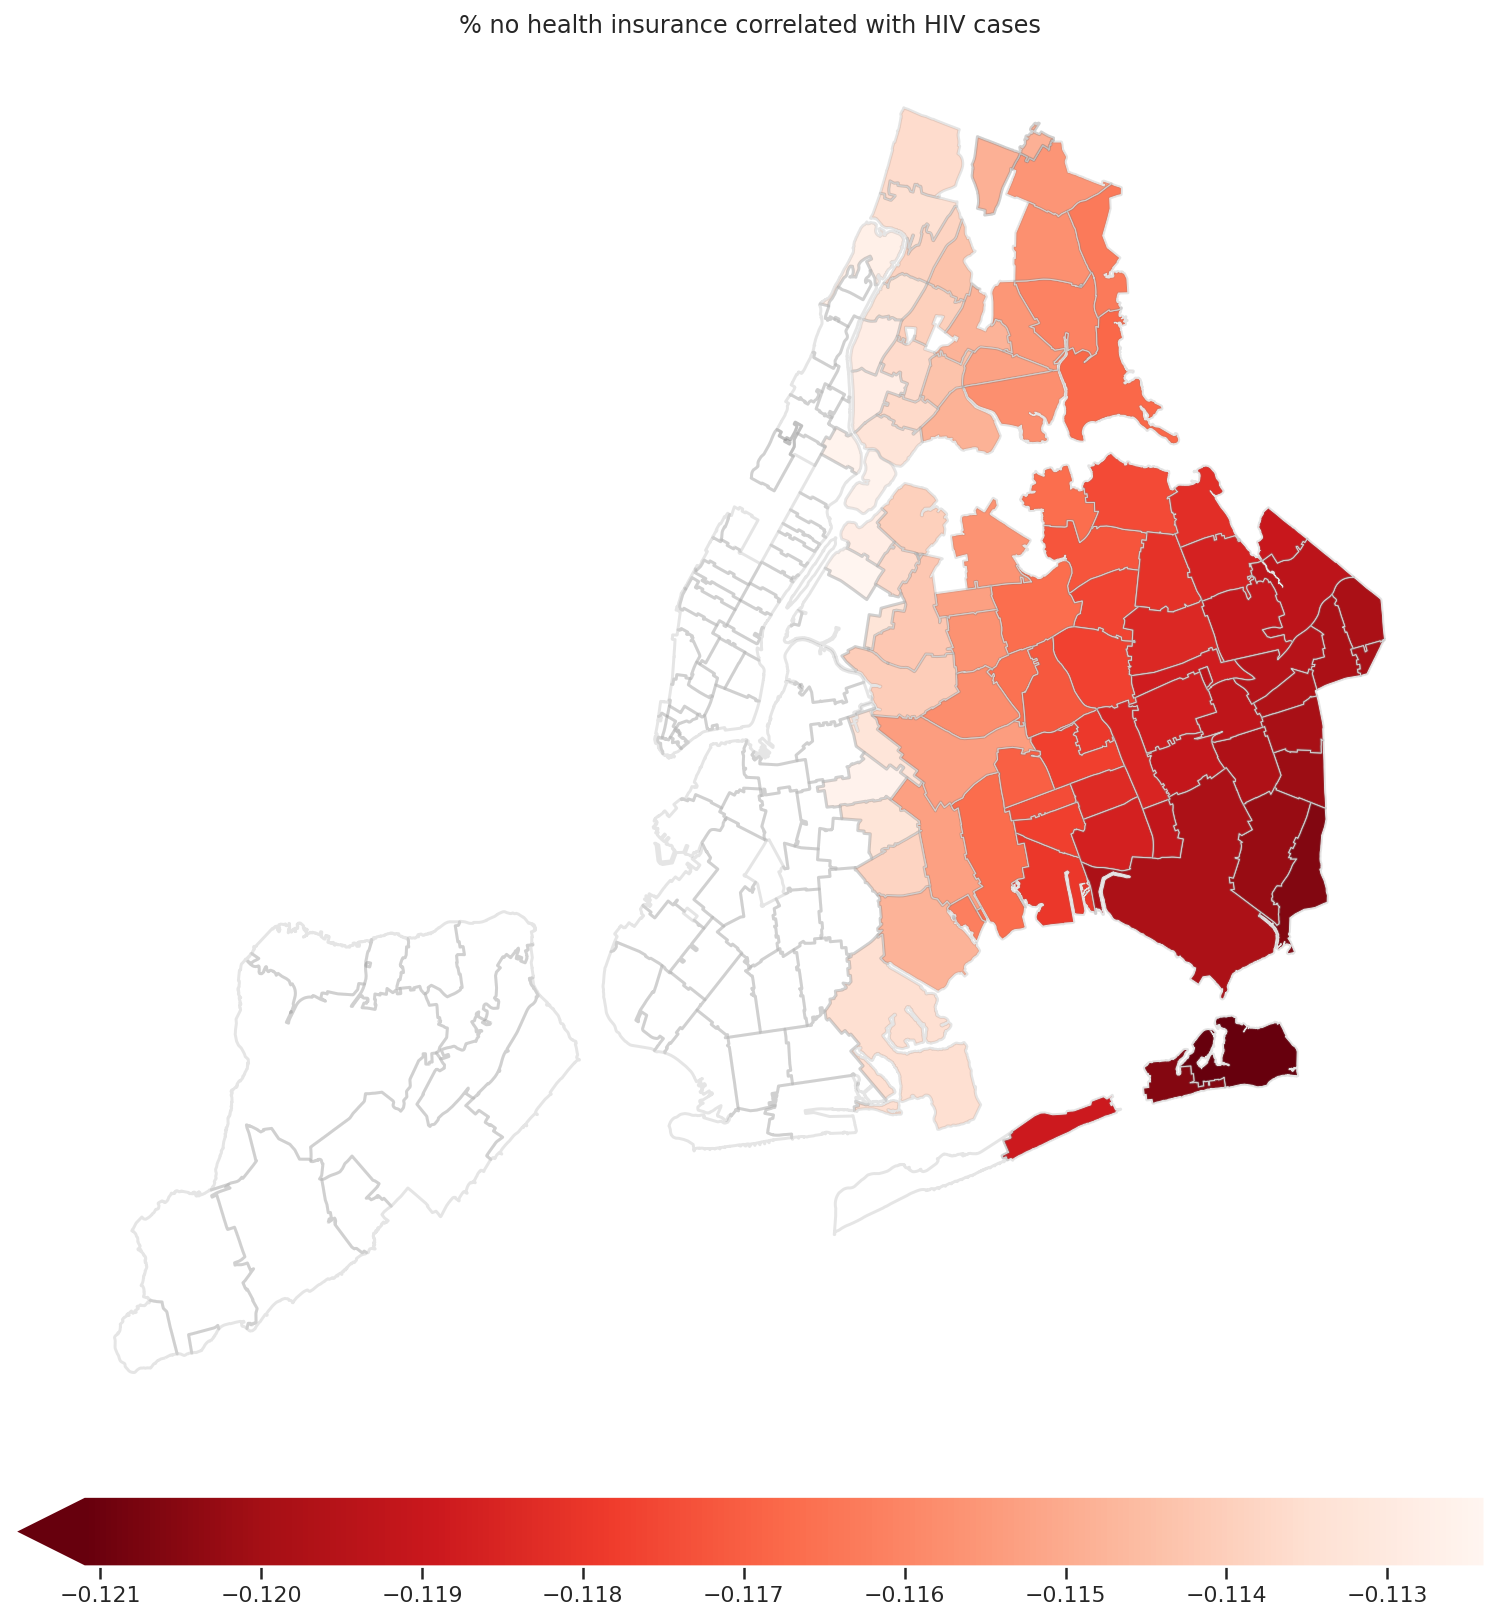

In [ ]:
mapp(col=final_geo,name='bt_%_no_health_insurance',color='Reds_r', title = '% no health insurance correlated with HIV cases', normal=False)

For the percentage of people with no health insurance, we are seeing similar trend with the percentage of people below poverty where the highest degree of negative correlation is concentrated at the East Queens area.